# Diversified Portfolio with Performance Evaluation

Code performs:

1. Define assets, one ETF per GICS sector (the SPDR sector ETFs).
2. Downloads 5 years of daily adjusted-close data (uses yfinance).
3. Computes daily returns and annualized mean & covariance.
4. Runs a constrained mean-variance style optimization that maximizes Sharpe ratio with the constraints:
    * weights sum to 1
    * 0 <= weight_i <= 0.20 for every sector
5. Calculates the portfolio returns, volatility, and Sharpe ratio. 
6. Builds the portfolio return series and computes beta vs SPY by regressing portfolio returns on SPY returns (OLS).
7. Results summary
    * Shows the final allocations and a bar chart.
    * Prints alpha/beta (daily and annualized) and shows a scatter + fitted line.

## Initial setup and network check and environment validation

In [ ]:
# Check python version, S/B: 3.10 to ensure the yfinance package functions as expected.
import sys

# Print python version
print("Python version:", sys.version)

# Print the executable path (useful to confirm which environment is used)
print("Python executable:", sys.executable) # 'sys.executable' -> Shows the path to the Python interpreter your notebook
# is using, which helps confirm that the kernel is pointing to the correct environment (e.g., 'py310')

Python version: 3.10.19 | packaged by Anaconda, Inc. | (main, Oct 21 2025, 16:41:31) [MSC v.1929 64 bit (AMD64)]
Python executable: c:\Users\ejoaq\anaconda3\envs\py310\python.exe


In [ ]:
# Test that ticker data can be pulled.
import yfinance as yf

aapl = yf.Ticker("AAPL")
data = aapl.history(period="5d")
#data = aapl.history(period="1mo") # use 1 month instead of 5 days.
print(data.head())

                                 Open        High         Low       Close  \
Date                                                                        
2025-11-20 00:00:00-05:00  270.829987  275.429993  265.920013  266.250000   
2025-11-21 00:00:00-05:00  265.950012  273.329987  265.670013  271.489990   
2025-11-24 00:00:00-05:00  270.899994  277.000000  270.899994  275.920013   
2025-11-25 00:00:00-05:00  275.269989  280.380005  275.250000  276.970001   
2025-11-26 00:00:00-05:00  276.959991  279.529999  276.630005  277.549988   

                             Volume  Dividends  Stock Splits  
Date                                                          
2025-11-20 00:00:00-05:00  45823600        0.0           0.0  
2025-11-21 00:00:00-05:00  59030800        0.0           0.0  
2025-11-24 00:00:00-05:00  65585800        0.0           0.0  
2025-11-25 00:00:00-05:00  46914200        0.0           0.0  
2025-11-26 00:00:00-05:00  33413600        0.0           0.0  


Use `yf.download` instead of `Ticker.history`; `yf.download` is more robust

In [ ]:
data = yf.download("AAPL", period="5d", interval="1d", auto_adjust=True) # `auto_adjust=True` returns adjusted close prices.
print(data.head())

[*********************100%***********************]  1 of 1 completed

Price            Close        High         Low        Open    Volume
Ticker            AAPL        AAPL        AAPL        AAPL      AAPL
Date                                                                
2025-11-20  266.250000  275.429993  265.920013  270.829987  45823600
2025-11-21  271.489990  273.329987  265.670013  265.950012  59030800
2025-11-24  275.920013  277.000000  270.899994  270.899994  65585800
2025-11-25  276.970001  280.380005  275.250000  275.269989  46914200
2025-11-26  277.549988  279.529999  276.630005  276.959991  33413600


### Check network/firewall

Make sure python can reach Yahoo Finance:

In [ ]:
import requests
r = requests.get("https://query1.finance.yahoo.com/v7/finance/download/AAPL")
print(r.status_code)

429


200 → network OK

Non-200 → firewall or network blocking Yahoo

### One-Cell Environment Validation Script

This test verifies:

✅ Your notebook is running under the correct Python 3.10 interpreter  
✅ All required libraries import without error  
✅ The library versions match the ones installed in your new conda environment  
✅ yfinance is functional (downloads AAPL data)  
✅ There are no import conflicts  

If everything prints green checkmarks (✅), then your new environment is fully set up and ready.

In [ ]:
#import sys
import importlib

print("🔍 VALIDATING PYTHON ENVIRONMENT\n")

# Check Python version
print(f"Python version: {sys.version}")
print(f"Executable: {sys.executable}\n")

# List of required packages
packages = ["numpy", "pandas", "matplotlib", "yfinance", "statsmodels"]

for pkg in packages:
    try:
        module = importlib.import_module(pkg)
        ver = getattr(module, "__version__", "unknown")
        print(f"✅ {pkg} imported successfully — version: {ver}")
    except Exception as e:
        print(f"❌ Error importing {pkg}: {e}")

# Quick functional test: small yfinance pull
print("\nTesting yfinance data download…")

import yfinance as yf

try:
    test = yf.Ticker("AAPL").history(period="5d")
    if not test.empty:
        print("✅ yfinance: Successfully downloaded sample price data (AAPL, 5 days)")
    else:
        print("❌ yfinance returned an empty dataset")
except Exception as e:
    print(f"❌ yfinance error: {e}")

print("\n🎉 Environment validation complete!")

🔍 VALIDATING PYTHON ENVIRONMENT

Python version: 3.10.19 | packaged by Anaconda, Inc. | (main, Oct 21 2025, 16:41:31) [MSC v.1929 64 bit (AMD64)]
Executable: c:\Users\ejoaq\anaconda3\envs\py310\python.exe

✅ numpy imported successfully — version: 2.2.6
✅ pandas imported successfully — version: 2.3.3
✅ matplotlib imported successfully — version: 3.10.8
✅ yfinance imported successfully — version: 0.2.66
✅ statsmodels imported successfully — version: 0.14.5

Testing yfinance data download…
✅ yfinance: Successfully downloaded sample price data (AAPL, 5 days)

🎉 Environment validation complete!


## To do:

1. Section 3: Compute returns -- need to display the covariance matrix, to get a quick view of the relationship between assets. -ERODRIGUEZ, TUES 25NOV2025 15:41
2. Section 4: Optimization that maximizes Sharpe ratio, does not factor in a risk-free rate. For a more accurate and "real world" representation of the Sharpe ratio, include it in the optimizer. -ERODRIGUEZ, TUES 25NOV2025 15:35
3. Section 5: Sharpe ratio does not factor in a Risk-free rate of return value into the calc. This value should be included for a more accurate Sharpe value.
4. Section 5: The intercept $\alpha$, should this be the mean of the data, or can the constant "1" remain as the intercept value of the regression line?
5. Section 1: Code needs to be updated to 'accept' multiple assets per sector.
6. Section 4: A "deep-dive" / description of the optimizer is needed (competence as if you would be teaching it!). -ERODRIGUEZ, Sat 29NOV2025 15:43

## 0. Import Libraries

In [1]:
# diversified_portfolio_with_beta.py
# Paste into Jupyter or run as script.
# Requirements: yfinance, pandas, numpy, matplotlib, statsmodels, scipy
# Install if needed:
# pip install yfinance pandas numpy matplotlib statsmodels scipy

import datetime as dt
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.optimize import minimize

## 1. Define Assets and Benchmark

In [2]:
# ----------------------------
# 1) Define sector ETFs + SPY
# ----------------------------

# Choose one ETF per GICS sector for diversified exposure
# GICS - Global Industry Classification Standard
sector_etfs = {
    "Communication Services": "ESPO", # modified from XLC, ESPO - VanEck Video Gaming and eSports ETF for more focused exposure
    "Consumer Discretionary": "ONLN", # modified from XLY, ONLN - ProShares Online Retail ETF -- AMZN is a major holding
    "Consumer Staples": "KXI", # modified from XLP, KXI - Consumer Staples Select Sector SPDR Fund
    "Energy": "URA", # modified from XLE, URA - Uranium ETF for energy exposure; Uranium is a key component of nuclear energy, which is a major energy source for the rising data center industry.
    "Financials": "ARKF", # modified from XLF, ARKF - ARK Fintech Innovation ETF for more growth-oriented financial exposure; also, ARKF has a higher beta than XLF, which may be desirable for growth. Financial tech is cool, blockchain and all that.
    "Health Care": "ARKG", # modified from XLV, ARKG - ARK Genomic Revolution ETF for innovative healthcare exposure
    "Industrials": "ARKX", # modified from XLI, ARKX - ARK Space Exploration & Innovation ETF for industrial exposure focused on aerospace and innovation.
    "Information Technology": "QTUM", # modified from XLK, QTUM - Quantum Computing ETF for cutting-edge tech exposure; quantum computing is the future.
    "Materials": "GOAU", # modified from XLB, GOAU - Gold and Precious Metals ETF for materials exposure; gold is a traditional hedge and important material.
    "Real Estate": "RWO", # modified from XLRE, RWO - SPDR Dow Jones Global Real Estate ETF for global real estate exposure.
    "Utilities": "UTES", # modified from XLU, UTES - Global X U.S. Infrastructure Development ETF for utilities and infrastructure exposure.
}
sectors = list(sector_etfs.keys())
tickers = list(sector_etfs.values())
bench_ticker = "SPY"  # benchmark for beta

print("Sector ETFs (Dictionary):")
print("Sectors (keys): ", sector_etfs.keys())
print("Tickers (values): ", sector_etfs.values())

Sector ETFs (Dictionary):
Sectors (keys):  dict_keys(['Communication Services', 'Consumer Discretionary', 'Consumer Staples', 'Energy', 'Financials', 'Health Care', 'Industrials', 'Information Technology', 'Materials', 'Real Estate', 'Utilities'])
Tickers (values):  dict_values(['ESPO', 'ONLN', 'KXI', 'URA', 'ARKF', 'ARKG', 'ARKX', 'QTUM', 'GOAU', 'RWO', 'UTES'])


## 2. Download Price Data

In [3]:
# ----------------------------
# 2) Download price data
# ----------------------------

# Download ~5 years of daily adjusted close prices
# Why only 5 years? Longer periods may include structural changes in the market or sectors that could skew beta estimates.

end = dt.date.today()
start = end - dt.timedelta(days=5*365)  # ~5 years
all_tickers = tickers + [bench_ticker]

print(f"Downloading {len(all_tickers)} tickers from {start} to {end} ...")
raw = yf.download(all_tickers, start=start, end=end, progress=False, auto_adjust=True)

# yfinance can return different column layouts:
# - MultiIndex with top-level like 'Adj Close' (common)
# - MultiIndex with top-level like 'Close'
# - Single-level with ticker symbols (when auto_adjust=True it may return adjusted prices directly)
# Handle common cases robustly.
if isinstance(raw.columns, pd.MultiIndex):
    if "Adj Close" in raw.columns.get_level_values(0):
        prices = raw["Adj Close"].copy()
    elif "Close" in raw.columns.get_level_values(0):
        prices = raw["Close"].copy()
    else:
        # fallback: flatten to last level (tickers) and keep requested tickers
        prices = raw.copy()
        prices.columns = raw.columns.get_level_values(-1)
        prices = prices.loc[:, [c for c in prices.columns if c in all_tickers]]
else:
    # single-level columns — assume columns are tickers (or contain them). Keep only requested tickers.
    prices = raw.copy()
    prices = prices.loc[:, [c for c in prices.columns if c in all_tickers]]

# drop columns (assets) with no data (if any); e.g., if a ticker was invalid or had no data, then it will be removed from the dataframe.
# Identify columns with all NaN before dropping
cols_all_nan = prices.columns[prices.isna().all()].tolist()
if cols_all_nan:
    print("Dropping columns with all NaN values:", cols_all_nan)
prices = prices.dropna(axis=1, how='all') # drop columns where all values are NaN; the argument axis=1 means drop columns (not rows), how='all' means only if ALL values are NaN.

# Ensure we have all sector tickers present
missing = [t for t in tickers if t not in prices.columns]
if missing:
    raise RuntimeError(f"Missing data for tickers: {missing}. Check ticker names or network access.")

# Keep only tickers present (in case SPY is missing for some reason)
prices = prices[[t for t in all_tickers if t in prices.columns]]

# Drop rows with any NaN values (if any remain)
# Note: Failure to drop NaNs here may lead to errors (or kernel crashes) in downstream calcs.
if prices.isnull().values.any():
    print("Warning: Price data contains NaNs. Dropping rows with NaNs.")
    prices = prices.dropna() # Default is axis=0 (rows), how='any' means drop rows with any NaN values.

if not prices.empty:
    print("Download complete. Downloaded price data for tickers: ")
    print(prices.columns.tolist())
    print("for data range: ", prices.index.min(), "to", prices.index.max())
else:
    print("Download failed or returned empty DataFrame.")

Download complete. Downloaded price data for tickers: 
['ESPO', 'ONLN', 'KXI', 'URA', 'ARKF', 'ARKG', 'ARKX', 'QTUM', 'GOAU', 'RWO', 'UTES', 'SPY']
for data range:  2021-03-30 00:00:00 to 2025-11-28 00:00:00


## 3. Compute Returns

* Annualized Mean Returns
* Annualized Covariance
    * Covariance is a measure of how two assets move together.

In [4]:
# ----------------------------
# 3) Compute returns
# ----------------------------

# Computes daily simple returns and annaulized mean/covariance
# Simple rate of returns: (P_t - P_{t-1}) / P_{t-1}
# Covariance matrix of returns
returns = prices.pct_change().dropna()  # daily simple returns; pct_change() is a method that computes the percentage change between the current and a prior element.
daily_mu = returns.mean()               # daily mean returns
daily_cov = returns.cov()               # daily covariance
## returns.cov() calcs the pairwise covariance of columns (assets), excluding NA/null values.
## The result is a square matrix where the entry at row i and column j represents the covariance between asset i and asset j.
## Covariance is a measure of how two assets move together. A positive covariance means that the assets tend to move in the same direction, 
## while a negative covariance indicates they move in opposite directions, and zero covariance means no linear relationship,
## and the two variables are uncorrelated.

# Note: The annualized values below are market total returns for the specified time period, which in this case is ~5 years.
trading_days = 252
ann_mu = daily_mu * trading_days        # approximate annualized returns
ann_cov = daily_cov * trading_days      # approximate annualized covariance

# Focus on sector tickers for optimization (does not include SPY)
mu = ann_mu[tickers]
cov = ann_cov.loc[tickers, tickers] # This line extracts the covariance submatrix for the sector ETFs only, excluding the benchmark SPY.

Note: If the above 3) Compute returns section throws exceptions, or the kernel crashes (more likely), the problem may be due to missing data (NaNs in the dataset); the .cov() method will try to compute the covariance of columns with almost no overlapping data. This often causes **segfaults** - killing the kernel.

Solution:
1. Drop NaN data (chatgpt it)
2. Shorten the time period, as newer assets may not have the same level of historical data as more established assets, this will lead to the newer assets' gap in data.
3. Or, run the 3.1) SAFE RETURN + COVARIANCE COMPUTATION ------ code below (methods used here may be more stable than those above).

Note: To comment/uncomment multiple lines, high-light the lines and `Ctrl + /`

In [5]:
# # 3.1) SAFE RETURN + COVARIANCE COMPUTATION ----------

# # Make sure the DataFrame is clean and small
# prices = prices.sort_index()
# prices = prices.apply(pd.to_numeric, errors='coerce')
# prices = prices.dropna(axis=1, how='all')

# print("Prices shape:", prices.shape)

# # Compute returns safely
# returns = prices.pct_change().dropna(how="all")
# returns = returns.dropna(axis=1, how="all")

# print("Returns shape:", returns.shape)

# # Use numpy-based covariance (kernel-safe)
# cov_matrix = np.cov(returns.values.T)
# daily_cov = pd.DataFrame(cov_matrix, index=returns.columns, columns=returns.columns)

# daily_mu = returns.mean()

# # Annualize
# trading_days = 252
# ann_mu = daily_mu * trading_days
# ann_cov = daily_cov * trading_days

# mu = ann_mu[tickers]
# cov = ann_cov.loc[tickers, tickers]

## 4. Optimize

* Runs a constrained optimization to maximize Sharpe ratio.

In [6]:
# ----------------------------
# 4) Constrained optimization
#    Maximize Sharpe (assume rf=0)
#    Subject to: sum(w)=1, 0 <= w_i <= 0.20
# ----------------------------

# Runs a constrained optimization to maximize Sharpe ratio
# with max 20% allocation per sector ETF for a 100% total allocation portfolio.
# This code section calculates the optimal weights, where the objective function is to maximize the Sharpe ratio,
# for a diversified portfolio of sector ETFs.

# Sharpe ratio = (prr - rf) / sigma_p
# prr = portfolio rate of return
# rf = risk-free rate of return, typically a short-term government bond yield or a U.S. Treasury bill rate.
# Here we assume rf=0 for simplicity.
# sigma_p = portfolio volatility = sqrt(w^T * Cov * w)

# Sharpe ratio interpretation:
# A higher Sharpe ratio indicates better risk-adjusted performance.
# A Sharpe ratio > 1 is considered good, > 2 very good, > 3 excellent.
# Below 1: indicates suboptimal risk-adjusted returns.

n = len(tickers)
bounds = [(0.0, 0.20) for _ in range(n)]
cons = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0},) # Defines the constraint that the sum of weights equals 1.

# Objective: negative Sharpe (we'll maximize Sharpe)
# *** NOTE: port_ret = expected portfolio return is NOT factoring in risk-free rate here (assumed zero). ***

def neg_sharpe(w, mu, cov):
    port_ret = w.dot(mu) # calcs expected portfolio return
    port_vol = np.sqrt(w @ cov @ w) # calcs portfolio standard deviation (volatility)
    # protect against zero vol
    if port_vol <= 0:
        return 1e6
    return -port_ret / port_vol # negative Sharpe. Why negative? Most optimizers minimize functions, so to maximize Sharpe we minimize its negative.

# Starting guess: equal weights (but feasible? equal = 1/11 ~0.0909 <0.2 is fine)
x0 = np.repeat(1.0 / n, n)

# Runs a constrained optimization to find the portfolio weights that maximize the Sharpe ratio.
## method: Sequential Least Squares Programming (SLSQP), which supports both bounds and constraints.
opt = minimize(neg_sharpe, x0, args=(mu.values, cov.values),
               method='SLSQP', bounds=bounds, constraints=cons,
               options={'ftol':1e-9, 'maxiter':1000})

if not opt.success:
    print("Optimization did not converge. Message:", opt.message)
    # Fallback: use capped proportional allocation (simple heuristic)
    # allocate equal then cap at 0.2 and redistribute remainder proportionally among uncapped
    w = np.repeat(1.0 / n, n)
    caps = np.array([0.20]*n)
    # iterative water-fill redistribution
    def capped_equal(weights, cap):
        w = weights.copy()
        while True:
            over = w > cap
            if not over.any():
                break
            excess = (w[over] - cap[over]).sum()
            w[over] = cap[over]
            free = (~over)
            if free.sum() == 0:
                break
            w[free] = w[free] + excess / free.sum()
        return w
    w = capped_equal(np.repeat(1.0/n, n), caps)
else:
    w = opt.x

weights = pd.Series(w, index=tickers) # creates a pandas Series where earch value in w (the optimized weight) is assigned to its corresponding ticker symbol.
weights.index = [f"{t} ({sector})" for t, sector in zip(tickers, sectors)] # relables index to include ticker and sector name

What is the above section of code doing?? --ERODRIGUEZ, 27NOV2025 11:57

## 5. Portfolio Returns and Metrics

In [7]:
# ----------------------------
# 5) Portfolio returns and metrics
# ----------------------------
# Build portfolio daily returns from original daily returns (not annualized)
# Ensure alignment (use returns DataFrame)
port_daily_returns = (returns[tickers] @ w) # the '@' operator performs matrix multiplication (dot product); here it computes the weighted sum of returns for each day.
## I.e., for each day, it multiplies the return of each asset by its corresponding weight in the portfolio and sums these products to get the total portfolio return for that day.

# annualized return via geometric mean: (prod(1+r))^(trading_days/n) - 1
# This formula annualizes the portfolio return by taking the product of (1 + daily returns) over all days, raising it to the power of (trading_days / number of days), and subtracting 1.
# I.e., the formuala annualizes the portofolio's compounded return, adjusting for the actual number of days in the sample; this allows for performance evaluation on a yearly basis regardless of sample size.
if len(port_daily_returns) > 0:
    port_ann_return = np.prod(1 + port_daily_returns) ** (trading_days / len(port_daily_returns)) - 1
else:
    port_ann_return = np.nan

# annualized volatility    
port_ann_vol = port_daily_returns.std() * np.sqrt(trading_days)
# sharpe ratio
port_sharpe = (port_ann_return / port_ann_vol) if port_ann_vol>0 else np.nan

Explanation of variables:

`port_daily_returns` is the aggregate weighted daily returns; weighted based off the weights assigned per asset.  
`port_ann_return` is the **annualized return via geomtric mean**, or a **COMPOUNDED ANNUAL GROWTH RATE (CAGR)**. What is the geomtric mean and why use it?  

*The geometric mean (as opposed to the "basic" arithmetic mean) is used to consider the impact of **compounding**.  

$
    \text{Geometric Mean} = \left( \prod_{i=1}^{n} x_i \right)^{1/n} = \sqrt[n]{x_1 x_2 ... x_i} = {(x_1 x_2 ... x_i)}^{1/n}
$

the "-1" is subtracted at the end of a geometric mean calc when dealing with rates of return or growth rates to convert the growth factor back into a percentage or fractional return.

`port_ann_vol` is the **annualized volatility** of the portfolio's return. 
1. First, the standard deviation of the portfolio's daily returns (Pandas) Series is calculated via the (Numpy) .std() function.
2. Then, multiply this by the square root of the number of trading days. Why? The variance of returns is *proportional* to time, and therefore standard deviation (volatility) is proportional to the square root of time.

$
    \sigma_{annual} = \sigma_{daily} \times \sqrt{252}
$

*This metric provides a standardization, a comparable measure of a portfolio's risk and potential price fluctuations over a one-year period.

`port_sharpe` - the Sharpe ratio. The Sharpe ratio is a measure of **risk-adjusted returns** that helps investors compare the performance of different investments.  
    * A higher Sharpe ratio indicates that an investment is generating more return per unit of risk, meaning it's a more efficient use of capital.  
    * (If volatility is zero or negative, the Sharpe ratio is set to NaN to avoid division errors.)

Formula:

$$
\text{Sharpe Ratio} = \frac{R_x - R_f}{\sigma_x}
$$

where:  
 $R_x$ = Expected portfolio return  
 $R_f$ = Risk-free rate of return  
 $\sigma_x$ = Portfolio's volatility

* Grading thresholds:
    * < 1: Poor
    * 1-1.99: Good
    * 2-2.99: Very good
    * \> 3: Excellent

## 6. Model

In [ ]:
# ----------------------------
# 6) Compute beta vs SPY using OLS (returns regression)
#    Use daily returns aligned
# ----------------------------
# Ensure SPY present in returns
if bench_ticker not in returns.columns:
    raise RuntimeError(f"Benchmark {bench_ticker} not found in downloaded data.")

y = port_daily_returns.dropna()
x = returns[bench_ticker].loc[y.index].dropna()
# align
aligned = pd.concat([y, x], axis=1).dropna()
y_al, x_al = aligned.iloc[:,0], aligned.iloc[:,1]
X = sm.add_constant(x_al.values)
model = sm.OLS(y_al.values, X).fit()
alpha_daily = model.params[0]
beta = model.params[1]
alpha_annual = (1 + alpha_daily) ** trading_days - 1
# approximate annualized beta? beta is scale-invariant; just report beta and daily alpha/annual alpha
# model summary available as model.summary()

Explanation of variables:

`y`, **portfolio daily returns**, sets the *y* variable for the downstream plots to be created, and has the `.dropna()` method operate on the `port_daily_returns` Series to remove any NaNs (they should all be removed by now).  
`x`, **benchmark (SPY) daily returns**, sets the *x* variable for the downstream plots to be created, and also has the `dropna()` method operate on the data. This time around though, we are operating on the **benchmark** (SPY) ticker's returns by indexing into the `returns` DataFrame with the argument variable `bench_ticker`.  
* Important: The `.loc[y.index]` part ensures that only the returns corresponding to the dates present in the portfolio's daily returns are selected, *guaranteeing* both series are aligned by date.  

`aligned` is combining `y` and `x` "side-by-side". `pd.concat` combines multiple pandas objects (Series or DataFrames), the argumnent `axis=1` means "combine side-by-side" (column-wise), not stacked on top of each other as the typical concatenate operation.  
* Commonly done before regressions, return calculations, or correlations.  

The `y_al` and `x_al` variable assignment line is splitting the two columns of the `aligned` DataFrame into two seperate variables:
* `y_al` -> the first column; `.iloc` (integer-location based indexing method) selects rows/columns by integer index.
    * `:` specifies all rows, and `0` specifies the first column.
    * This effectively indexes out the first column of `aligned` that becomes `y_al`.
* `x_al` same logic applies, but the second column is selected. 

`X` is setting up a Numpy array of two columns, column 0 has all 1's and column 1 has the actual x-values (benchmark returns).
* `x_al` is a pandas Series, the `.values` function converts it into a Numpy array. Statsmodels prefers Numpy arrays for regression input.
* `sm.add_constant` adds a column of 1's to the data; regression models need an intercept term.
    * This allows the model to estimate:  
    $
    y = \alpha + \beta x
    $  
    where $\alpha$ is the intercept (w/out this value, the regression line is forced through the origin).

`model` is the regression *object* built using the sm.OLS *class*; based on the **Ordinary Least Squares (OLS)** statistical method to find the best-fitting straight line through a set of data points by minimizing the SS of the vertical distance between the points and the line.
* `sm.OLS(y_values, X)` creates the OLS regression object:
    * Dependent variable (y) -> `y_al.values`
    * Independent variables (X) -> the constant + x-values
    (this call sets up the regression but doesn't "run it" yet)

    * `.fit()` method actually runs the regression and computes:
        * $\alpha$ (intercept)
        * β (slope)
        * R-squared
        * p-values
        * $\epsilon$ Standard error
        * Residuals

    * Simple linear regression:
        * $ y_{al} = \alpha + \beta · x_{al} + \epsilon $

`alpha_daily` and `beta` are the intercept $\alpha$, also called the daily alpha, and $\beta$, which is the regression coefficient, respectively.
* $\beta$ measures how sensitive y is to x.
    * $\beta$ > 1 -> y is more volatile than x  
    * $\beta$ < 1 -> y moves less than x

`alpha_annual` converts daily alpha into an annualized alpha using *compounding*.
* Why? If alpha is a daily number (like 0.0002 = 0.02%/day), you don’t multiply by 252.
* Returns compound:
    * Annual return = (1 + daily return)^252 - 1
* So:
    * 1 + alpha_daily → daily growth factor
    * raised to trading_days (usually 252)
    * minus 1 → converts back to a return
* Example:
    * If daily alpha = 0.0003:
    * alpha_annual = (1.0003)^252 - 1 ≈ 0.076 → 7.6%

## 7. Results Summary


Optimized weights (each <= 20%):


KXI (Consumer Staples)          0.2000
UTES (Utilities)                0.2000
GOAU (Materials)                0.2000
QTUM (Information Technology)   0.2000
URA (Energy)                    0.1353
ESPO (Communication Services)   0.0647
ONLN (Consumer Discretionary)   0.0000
ARKX (Industrials)              0.0000
ARKG (Health Care)              0.0000
ARKF (Financials)               0.0000
RWO (Real Estate)               0.0000
dtype: float64

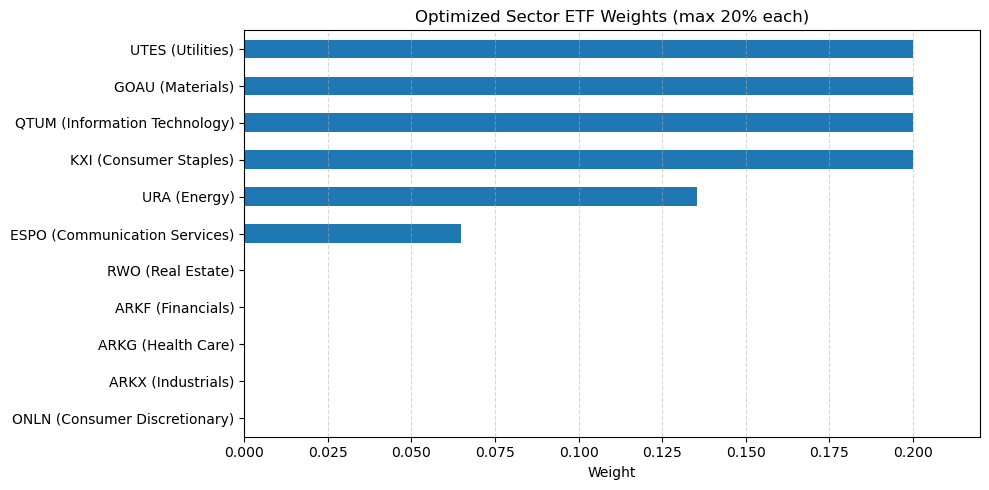


Weights table:


,Sector,Weight
Ticker,,
ESPO,Communication Services,0.0647
ONLN,Consumer Discretionary,0.0000
KXI,Consumer Staples,0.2000
URA,Energy,0.1353
ARKF,Financials,0.0000
ARKG,Health Care,0.0000
ARKX,Industrials,0.0000
QTUM,Information Technology,0.2000
GOAU,Materials,0.2000


In [ ]:
# ----------------------------
# 7) Print results and plot
# ----------------------------
pd.set_option('display.float_format', '{:,.4f}'.format)
# Display optimized weights in descending order in a table.
print("\nOptimized weights (each <= 20%):")
display(weights.sort_values(ascending=False))

# Plot weights
plt.figure(figsize=(10,5))
weights.sort_values(ascending=True).plot(kind='barh')
plt.title("Optimized Sector ETF Weights (max 20% each)")
plt.xlabel("Weight")
plt.xlim(0,0.22)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Optional: show weights as DataFrame
weights_df = pd.DataFrame({
    "Sector": sectors,
    "Ticker": tickers,
    "Weight": w
}).set_index("Ticker")
print("\nWeights table:")
display(weights_df)

In [ ]:
# Portfolio metrics
print("\nPortfolio annualized return (approx): {:.2%}".format(port_ann_return))
print("Portfolio annualized volatility: {:.2%}".format(port_ann_vol))
print("Portfolio annualized Sharpe (rf=0): {:.3f}".format(port_sharpe))

Description of metrics:
* **Annualized return**: Is the **compounded annual growth rate (CAGR)**, which is based on the aggregate weighted daily returns.  
    * Recall: CAGR is the annualized return via geometric mean (as opposed to the "basic" arithmetic mean).  

* **Annualized volatility**: This metric provides a standardization, a comparable measure of a portfolio's risk and potential price fluctuations over a one-year period.  

* **Annualized Sharpe ratio**: Calculated by determining the portfolio's "excess return" for a given time period, then dividing that by the portfolio's standard deviation, which is a measure of the portfolio's volatility risk.  
    * The portfolio's excess returns are the returns above the rate of return of a risk-free asset, usually a short-term U.S. government bond.
    * If a bond is paying 3% interest, and the porfolio earned 10%, then the excess return is 7%. :)
    * The Sharpe ratio gives insight into the tradeoff between risk and return.
    * Recall: 
        * Grading thresholds:
            * < 1: Poor
            * 1-1.99: Good
            * 2-2.99: Very good
            * \> 3: Excellent

In [ ]:
# Print regression results
print("\nRegression vs SPY (daily):")
print(f"  Alpha (daily): {alpha_daily:.6f}")
print(f"  Alpha (annualized): {alpha_annual:.4%}")
print(f"  Beta: {beta:.4f}")

Description of results:  

* The OLS regression is of daily portfolio returns on daily SPY returns.
    * Mathematically $\alpha$ daily is the model's intercept; in investing, and per this model, alpha represents the portion of a portfolio's return that is independent of market movements.  
        * **Positive alpha**: Indicates that the investment has outperformed its expected return after adjusting for risk. An $\alpha = 1.0$ means the investment *outperformed its benchmark* by 1%.
        * **Negative alpha**: Suggests the investment has *underperformed* its expected return.
        * **Zero alpha**: Means the return matches the benchmark, in line with the risk taken.
    
    * Beta, or the beta coefficient, quantifies the sensitivity of an investment's *returns* to changes in the benchmark, which by definition has a beta of 1.0.
        * Mathematically $\beta$ is the slope of the line.
        * **Beta > 1**: The investment is more volatile than the market. A beta of 1.5 suggests the stock is 50% more volatile, meaning it is expected to move 1.5 times as much as the market in either direction (up or down).
        * **Beta < 1**: The investment is *less* volatile than the market. Low-beta assets, are often **considered more stable** and may hold up better during market downturns.
        * **Negative beta**: The investment moves inversely to the market, which is rare, but possible for certain asset classes or strategies designed to hedge market risk.

**Important: Both alpha and beta are historical measures, and by no means guarantee future results.**

In [ ]:
# Print OLS summary
print("\nOLS summary:\n")
print(model.summary())

Ordinary Least Squares Regression Summary:
* [Should describe what each one of these values are, but for now, adj. R-squared is the most obvious metric of how well the model fits the data.]

In [ ]:
# Scatter plot portfolio vs SPY daily returns with fitted line
plt.figure(figsize=(7,6))
plt.scatter(x_al, y_al, alpha=0.4, s=10)
xmin, xmax = x_al.min(), x_al.max()
x_line = np.linspace(xmin, xmax, 100) # Query points for fitted line
y_line = alpha_daily + beta * x_line # Fitted line values
plt.plot(x_line, y_line, linewidth=2, label=f"Fit: alpha={alpha_daily:.6f}, beta={beta:.3f}")
plt.xlabel("SPY daily return")
plt.ylabel("Portfolio daily return")
plt.title("Portfolio vs SPY (daily returns)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

The scatter plot plots the portfolio daily returns vs the benchmark (SPY) returns, plotting the data for the selected time period, which in this case is less than the selected 5 years (many rows were dropped off due to lack of data).
* The fitted line's parameters are listed in the legend.